## Quantum Annealing for odd-odd nuclei

#### Imports

In [28]:
from collections import Counter
from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState,QuadrupoleOperator,J2operator,write_j_square_twobody_file
import numpy as np
import torch
from typing import Dict
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
import scipy
from typing import List

def plot_spectrum(eigenvalues):
    """
    Plot the vertical spectrum of a Hamiltonian, showing the eigenvalues as horizontal lines 
    and indicating their degeneracy.

    Parameters:
    eigenvalues (array-like): Array of eigenvalues of the Hamiltonian.
    """
    # Count the degeneracy of each eigenvalue
    degeneracy = Counter(eigenvalues)

    # Prepare data for plotting
    unique_eigenvalues = list(degeneracy.keys())
    degeneracies = list(degeneracy.values())

    # Plot the spectrum
    plt.figure(figsize=(6, 10))
    for i, (eig, deg) in enumerate(zip(unique_eigenvalues, degeneracies)):
        plt.hlines(eig, i - 0.2 * deg, i + 0.2 * deg, colors='b', linewidth=5)
        plt.text(i, eig, f'{deg}', horizontalalignment='center', verticalalignment='bottom', fontsize=24, color='r')

    # Make the plot fancy
    plt.title('Spectrum of the Hamiltonian', fontsize=16)
    plt.ylabel('Eigenvalue', fontsize=14)
    plt.xlabel('Index (degeneracy indicated by text)', fontsize=14)
    plt.xticks(range(len(unique_eigenvalues)), ['']*len(unique_eigenvalues))  # Remove x-axis ticks
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    # Show the plot
    plt.show()

file_name:str='data/cki'

write_j_square_twobody_file(filename=file_name)

j_square_filename:str=file_name+'_j2'
qq_filename='data/qq.p'
SPS=SingleParticleState(file_name=file_name)
energies:List=SPS.energies

J= [0. 1. 2. 3.]
J= [1. 2.]
J= [1. 2.]
J= [0. 1.]


#### Hyperparameters

In [29]:
nparticles_a:int=2
nparticles_b:int=2

size_a:int=SPS.energies.shape[0]//2
size_b:int=SPS.energies.shape[0]//2
title=r'$^{12}$Be'
# p shell
# Li8 (3,1), B10 (3,3), Li12 (3,5), Li6 (1,1)
# sd shell
# F18 (1,1), F20 (3,1), Na22 (3,3)

J and M operator and the single particle Basis

In [30]:
matrix_qq,_=get_twobody_nuclearshell_model(file_name=qq_filename)

energies=SPS.energies



Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:02<00:00,  5.55it/s]


$J^2$, $Q^2$ and $M$ operators

In [31]:
J2cki=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=j_square_filename,symmetries=[SPS.total_M_zero])


Moperator = FermiHubbardHamiltonian(
    size_a=size_a,
    size_b=size_b,
    nparticles_a=nparticles_a,
    nparticles_b=nparticles_b,
    symmetries=[SPS.total_M_zero]
)


diag_m:List=[]
for state in SPS.state_encoding:
    n,l,j,m,t,tz=state
    diag_m.append(m)

Moperator.get_external_potential(diag_m)
Moperator.get_hamiltonian()


QQoperator=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
QQoperator.get_twobody_interaction(twobody_dict=matrix_qq)
QQoperator.get_hamiltonian()


Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:01<00:00,  7.45it/s]
592it [00:00, 684.71it/s]
1256it [00:01, 736.91it/s]


#### Target Hamiltonian

We get the entries of the two-body matrix $v_{abcd}$ in the decoupled basis from the coupled basis

In [32]:
twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)



Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:02<00:00,  5.72it/s]


Now, we can initialize the NSM Hamiltonian (fixing the basis at $M=0$ subspace) and measure both J and M (just to check)

In [33]:
TargetHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
TargetHamiltonian.get_external_potential(external_potential=energies[:size_a+size_b])
TargetHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
TargetHamiltonian.get_hamiltonian()


nlevels=2

egs,psis=TargetHamiltonian.get_spectrum(n_states=nlevels)

print('Hamiltonian shape=',TargetHamiltonian.hamiltonian.shape)

egs=egs[0]
print(egs)
psi0=psis[:,:1]

print('M value ground state=',SPS.compute_m_exp_value(psi0,basis=TargetHamiltonian.basis),'\n')
print('total_m=',psi0.transpose().conjugate().dot(Moperator.hamiltonian.dot(psi0)))
print('total J value=',J2cki.j_value(psi=psi0),'\n')
print('deformation=',psi0.transpose().conjugate().dot(QQoperator.hamiltonian.dot(psi0)))
print(TargetHamiltonian.entanglement_entropy(indices=[i for i in range(size_a)],psi=psi0))



size= 12 6


0it [00:00, ?it/s]

1424it [00:02, 663.07it/s]


Hamiltonian shape= (51, 51)
-30.29539461360554
M value ground state= [1.38777878e-17] 

total_m= [[0.]]
(1, 1)
total J value= [[5.88418203e-15]] 

deformation= [[-7.11447171]]
rho check= 0.9999999999999997 (64, 64)
2.2719485669765103


#### Driver Hamiltonian 

Here we get the Slater determinant of the many-body basis that minimizes the Hamiltonian

In [34]:
# We select the product state of the basis that minimizes the Hamiltonian
min = 10000
min_b=0.
for i, b in enumerate(TargetHamiltonian.basis):
    psi = np.zeros(TargetHamiltonian.basis.shape[0])
    psi[i] = 1.0
    value = np.conj(psi) @ TargetHamiltonian.hamiltonian @ psi
    if value < min:
        min = value
        #print(value)
        #print(b)
        psi_base = psi
        min_b=b
        
print(min_b)
print('M value minimum slater=',psi_base.transpose().conjugate().dot(Moperator.hamiltonian.dot(psi_base)),'\n')


[1 0 0 1 0 0 1 0 0 1 0 0]
M value minimum slater= 0.0 



Use our driving Hamiltonian with the |m| monotonic occupation

In [37]:

min_b=np.zeros(size_a+size_b)
min_b[0]=1
#min_b[1]=1
#min_b[2]=1
min_b[3]=1

min_b[0+size_a]=1
#min_b[1+size_a]=1
#min_b[2+size_a]=1
min_b[3+size_a]=1




print('initial state=',min_b)

InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])

kinetic_term:Dict={}
adj_matrix=np.zeros((size_a+size_b,size_a+size_b))



idx=InitialHamiltonian._get_index(element=min_b)
print('idx=',idx)
psi_configuration=np.zeros(TargetHamiltonian.hamiltonian.shape[0])
psi_configuration[idx]=1
min=psi_configuration.transpose().dot(TargetHamiltonian.hamiltonian.dot(psi_configuration))      
external_field=np.zeros(size_a+size_b)


external_field=-1*(np.abs(min)/(nparticles_a+nparticles_b))*min_b
print('min energy=',min)
InitialHamiltonian.get_external_potential(external_field)
InitialHamiltonian.get_hamiltonian()

nlevels=3

es,psis=InitialHamiltonian.get_spectrum(n_states=nlevels)
einitial=es[0]
psi_initial=psis[:,0]
print(psi_initial)
print('psi initial vs psi configuration',psi_initial-psi_configuration,'\n')
print('total_m=',SPS.compute_m_exp_value(psi=psi_initial,basis=InitialHamiltonian.basis))
#print('total J^2=',psi_initial.transpose().conjugate() @ Joperator.hamiltonian @ psi_initial)
print('GS ENERGY=',es[0])
from fractions import Fraction
print('M value initial state=',psi_initial.transpose().conjugate().dot(Moperator.hamiltonian.dot(psi_initial)),'\n')
# Helper function to convert a float to a LaTeX-formatted fraction
def format_as_latex_fraction(value):
    frac = Fraction(value).limit_denominator(10)  # Convert float to fraction
    if frac.denominator == 1:
        return rf"{frac.numerator}"  # Integer case
    else:
        return rf"\frac{{{frac.numerator}}}{{{frac.denominator}}}"  # Fraction case



initial state= [1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
idx= 5
min energy= -15.405709999999996
[ 1.98707485e-17  5.15357858e-17  2.85050473e-17 -7.80262990e-18
  3.05147376e-17  1.00000000e+00  2.88714944e-18 -3.68625481e-17
  3.37484167e-17 -2.49061736e-17  3.72495956e-17 -2.45318770e-17
 -1.06593424e-17 -2.17050733e-17 -2.53915189e-17  5.07199784e-18
 -3.03389694e-18 -3.28812335e-18  3.27829054e-18  1.80455598e-17
 -5.47612366e-18 -1.68359854e-17 -2.07712048e-18  2.59194932e-17
  3.47616668e-19 -3.70827522e-17  2.20528896e-17  2.88953065e-18
 -2.49106715e-17  6.08194654e-18  2.97628817e-18 -4.08098274e-17
  1.43846725e-17  7.83136985e-17 -2.05058482e-17 -3.35734205e-18
 -2.02183170e-17  3.78946253e-18  9.22278949e-18  9.73684995e-19
 -2.23443517e-17  7.07997166e-18  1.02499646e-17 -5.92558166e-18
 -2.84844452e-17 -4.04283789e-18  9.55696714e-19  1.26069683e-17
  9.47120972e-18  4.30289947e-18 -2.87829759e-19]
psi initial vs psi configuration [ 1.98707485e-17  5.15357858e-17  2.85050473e

#### Single Particle Hamiltonian

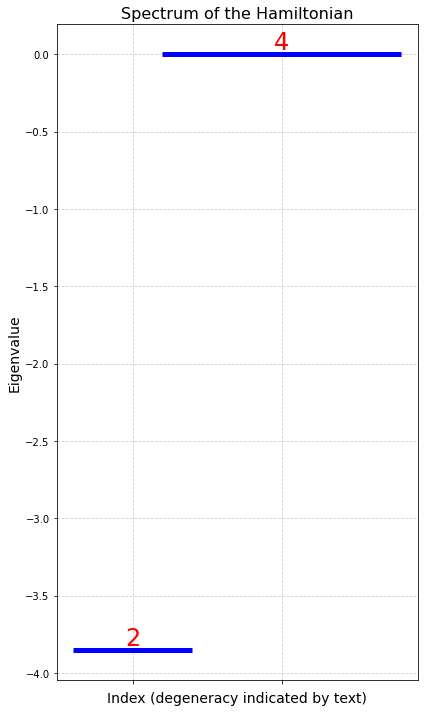

[-3.8514275 -3.8514275  0.         0.         0.         0.       ]


In [38]:
single_particle_hamiltonian=adj_matrix[:size_a,:size_a]+external_field[:size_a,None]*np.eye(size_a)


eigenvalues,states=np.linalg.eigh(single_particle_hamiltonian)

plot_spectrum(eigenvalues)
print(eigenvalues)
nstate=0


#### Annealing

We perform the spectrum using the $\lambda$ parametrization

In [ ]:
ngrid=100
nlevels=2
lambd=np.linspace(0,1.,ngrid)

spectrum=np.zeros((nlevels,ngrid))
psi_spectrum = np.zeros((nlevels, InitialHamiltonian.basis.shape[0]))
n_evolution=np.zeros((nlevels,ngrid, InitialHamiltonian.basis.shape[-1]))
j_values=np.zeros_like(spectrum)
m_values = np.zeros_like(spectrum)
qq_values=np.zeros_like(spectrum)

comm=np.zeros_like(spectrum)
plt.plot(lambd)
plt.plot(1-lambd)
plt.plot(lambd*(1-lambd))

for i in trange(ngrid):

    ham=lambd[i]*TargetHamiltonian.hamiltonian+(1-lambd[i])*InitialHamiltonian.hamiltonian#+lambd[i]*(1-lambd[i])*IntermediateHamiltonian.hamiltonian   

    values,psis=eigsh(ham,k=nlevels,which='SA')
    if i==0:
        print('PSI DIFFERENCE',psis[:,0]-psi_initial)
    for a in range(psis.shape[-1]):   
        j_values[a,i]=J2cki.j_value(psi=psis[:,a])
        m_values[a,i]=psis[:,a].transpose().conjugate().dot(Moperator.hamiltonian.dot(psis[:,a]))
        qq_values[a,i]=psis[:,a].transpose().conjugate().dot(QQoperator.hamiltonian.dot(psis[:,a]))
    spectrum[:,i]=values

Plots

IndexError: index 2 is out of bounds for axis 0 with size 2

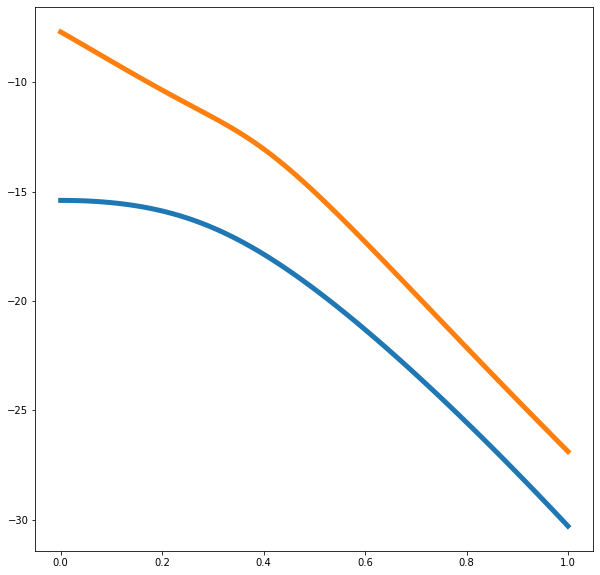

In [40]:
plt.figure(figsize=(10,10))
for i in range(5):
    #if np.abs(m_values[i,0])<10**-5:
    plt.plot(lambd,spectrum[i],label=f'level={i}',linewidth=5)

plt.xlabel(r'$\lambda$',fontsize=40)
plt.ylabel(r'$e_i(\lambda)$',fontsize=40)

#plt.legend(fontsize=20)
plt.tick_params(which='major',labelsize=20)
plt.title(title,fontsize=30)
plt.show()


print('Analysis of the gap \n')
t_critic=np.argmax(spectrum[0])
gap=np.min(np.abs(spectrum[1,:]-spectrum[0,:]))
print((gap))
print(spectrum[0,-1])



M and commutators

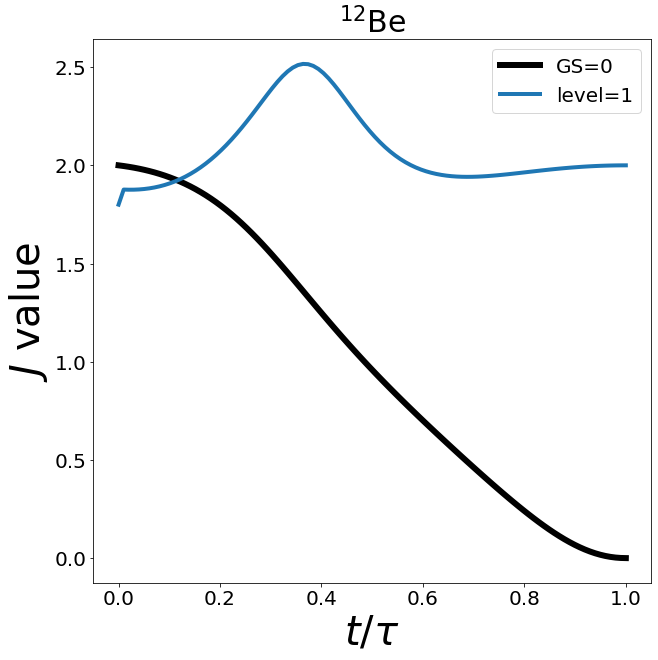

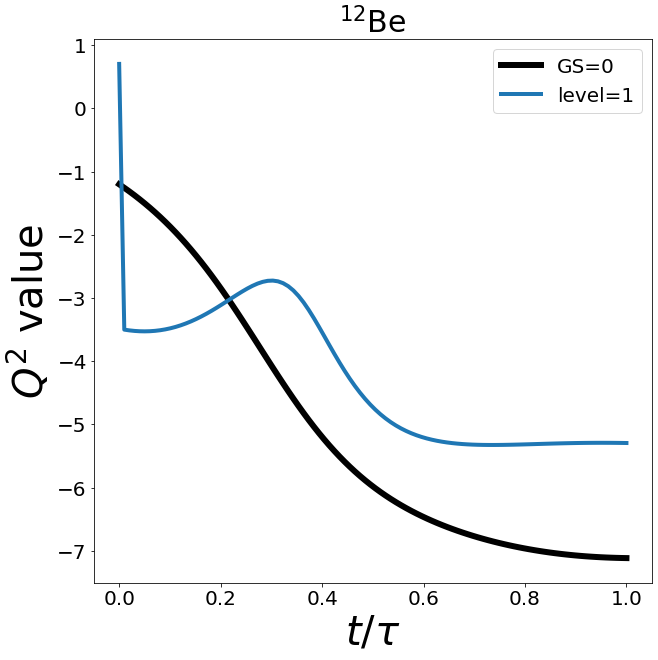

In [41]:




plt.figure(figsize=(10, 10))
plt.title(title,fontsize=30)
for i in range(nlevels):
    if i==0:
        plt.plot(lambd,j_values[i],label=f'GS={i}',linewidth=6,color='black',)
    else:
        plt.plot(lambd,j_values[i],label=f'level={i}',linewidth=4)
plt.legend(fontsize=20)

#plt.axhline(y=0,color='red',linestyle='--',linewidth=3)
plt.xlabel(r'$t/\tau$',fontsize=40)
plt.ylabel(r'$J$ value',fontsize=40)
plt.tick_params(which='major',labelsize=20)
# plt.xlim([0.9,1])
plt.show()


plt.figure(figsize=(10, 10))
plt.title(title,fontsize=30)
for i in range(nlevels):
    if i==0:
        plt.plot(lambd,qq_values[i],label=f'GS={i}',linewidth=6,color='black')
    else:
        plt.plot(lambd,qq_values[i],label=f'level={i}',linewidth=4)
plt.legend(fontsize=20)

#plt.axhline(y=0,color='red',linestyle='--',linewidth=3)
plt.xlabel(r'$t/\tau$',fontsize=40)
plt.ylabel(r'$Q^2$ value',fontsize=40)
plt.tick_params(which='major',labelsize=20)
# plt.xlim([0.9,1])
plt.show()

#### Time Evolution

In [ ]:

### final time of the simulation
tf = 20

### we fix the nsteps such that dt=0.1
nstep=int(tf*10)


nlevels=2
time = np.linspace(0.0, tf, nstep)

### psi is initialized to be the gs of the target hamiltonian
psi = psi_initial

### we stored the spectrum
spectrum = np.zeros((nlevels, nstep))
probabilities=np.zeros((nlevels, nstep))

### we need the dt for the simulation
dt=time[1]-time[0]

### stored energy (variance is deprecated actually)
eng_t=[]
variance_t=[]

### stored fidelity
fidelity_t=[]
fidelity_psi0_t=[]
ipr_t=[]
entropy_pn_t=[]
lambd=1-time/tf
#gamma=1/(tf/2)
#lambd=np.exp(-gamma*time)
for i in trange(nstep):

    time_hamiltonian = (
        InitialHamiltonian.hamiltonian * ( lambd[i])
        + TargetHamiltonian.hamiltonian * (1-lambd[i])
    ) #+lambd[i]*(1-lambd[i]) * IntermediateHamiltonian.hamiltonian
    values, psis = eigsh(time_hamiltonian, k=nlevels, which="SA")
    psi=expm_multiply(-1j*dt*time_hamiltonian,psi)

    ### compute the IPR
    ipr_t.append(np.sum((psi.conjugate()*psi)**2))
    
    ### entropy np
    entropy_pn_t.append(TargetHamiltonian.entanglement_entropy(indices=[i for i in range(size_a)],psi=psi))
    
    e_ave=psi.conjugate().transpose()@ time_hamiltonian @ psi
    e_square_ave = (
        psi.conjugate().transpose() @ time_hamiltonian @ time_hamiltonian @ psi
    )
    eng_t.append(e_ave)
    variance_t.append(e_square_ave-e_ave**2)
    spectrum[:, i] = values
    
    fidelity_psi0_t.append((psi0.conjugate().transpose() @ psi[:]
                ) * np.conj(psi0.conjugate().transpose() @ psi[:]))

    degenerate_fidelity=0.
    count=0
    for j in range(values.shape[0]):
        if np.isclose(values[j],values[0]):
            degenerate_fidelity += (
                psis[:, j].conjugate().transpose() @ psi[:]
            ) * np.conj(psis[:, j].conjugate().transpose() @ psi[:])
            count=count+1
        
        probabilities[j,i]=(
                psis[:, j].conjugate().transpose() @ psi[:]
            ) * np.conj(psis[:, j].conjugate().transpose() @ psi[:])

    fidelity=degenerate_fidelity        
    fidelity_t.append(fidelity)

eng_t=np.asarray(eng_t)
fidelity_t=np.asarray(fidelity_t)
fidelity_psi0_t=np.asarray(fidelity_psi0_t)
variance_t=np.asarray(variance_t)
print(np.abs((egs-eng_t[-1])/egs))
print(fidelity)
print(eng_t.shape)
ipr_t=np.asarray(ipr_t)

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


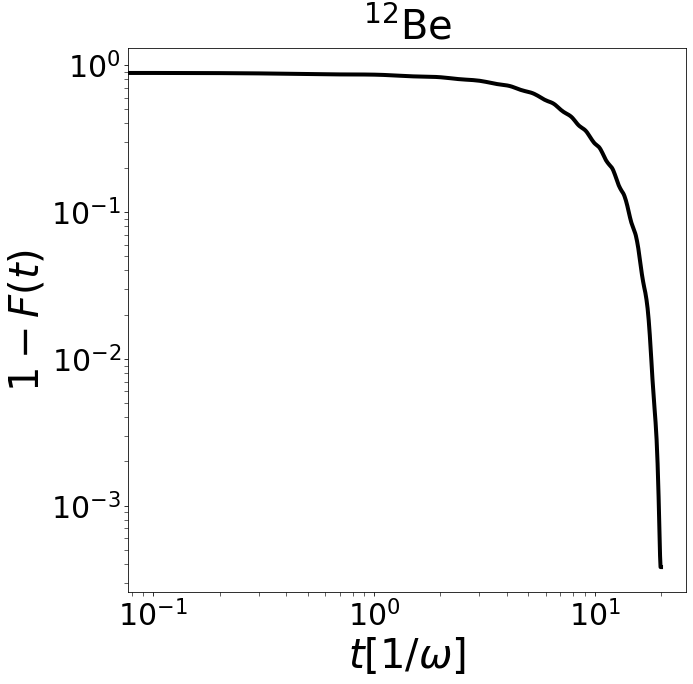

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


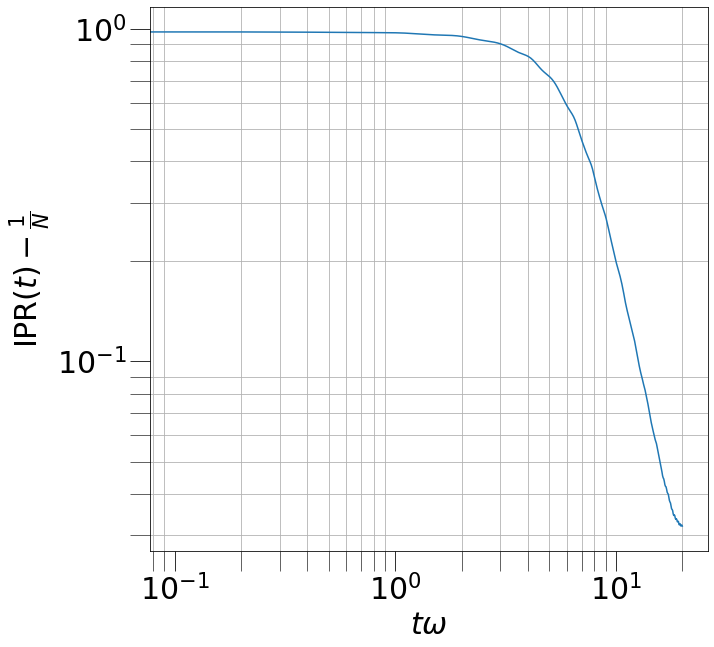

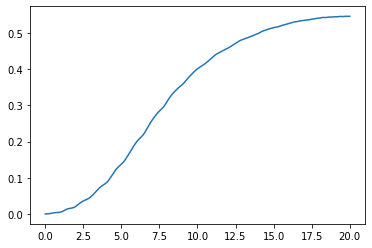

In [45]:
plt.figure(figsize=(10,10))
plt.plot(time,1-fidelity_psi0_t,linewidth=4,color='black')
plt.tick_params(which='major',labelsize=30,length=4)
plt.tick_params(which='minor',length=4)
plt.loglog()
plt.xlabel(r'$t[1/\omega]$',fontsize=40)
plt.title(title,fontsize=40)
plt.ylabel(r'$1-F(t)$',fontsize=40)
plt.show()

plt.figure(figsize=(10,10))
plt.plot(time,ipr_t-1/psi.shape[0])
plt.xlabel(r'$t\omega$',fontsize=30)
plt.ylabel(r'$\mathrm{IPR}(t)-\frac{1}{N}$',fontsize=30)
plt.tick_params(which='major',labelsize=30,length=20)
plt.tick_params(which='minor',labelsize=30,length=20)
plt.grid(True,which='minor')
plt.loglog()
plt.show()


plt.plot(time,np.asarray(entropy_pn_t)/np.log(2**size_a))
plt.show()

##### Let's study this weird behaviour of FIG. 2

this is a kind of weird behaviour or not? Who knows

-it does not depend on the time step
-it does not depend on the number of levels

In [ ]:
time_pure=np.arange(1,100,10)
f_vs_t=[]
for t0 in time_pure:
    tf = t0
    nstep=int(tf*10)
    print(nstep)
    nlevels=3
    time = np.linspace(0.0, tf, nstep)
    print(time[1]-time[0])
    psi = psi_initial
    spectrum = np.zeros((nlevels, nstep))
    probabilities=np.zeros((nlevels, nstep))
    dt=time[1]-time[0]
    eng_t=[]
    variance_t=[]
    fidelity_t=[]
    
    lambd=1-time/tf
    #gamma=1/(tf/2)
    #lambd=np.exp(-gamma*time)
    for i in trange(nstep):

        time_hamiltonian = (
            InitialHamiltonian.hamiltonian * ( lambd[i])
            + TargetHamiltonian.hamiltonian * (1-lambd[i])
        ) #+lambd[i]*(1-lambd[i]) * IntermediateHamiltonian.hamiltonian
        values, psis = eigsh(time_hamiltonian, k=nlevels, which="SA")
        psi=expm_multiply(-1j*dt*time_hamiltonian,psi)

        e_ave=psi.conjugate().transpose()@ time_hamiltonian @ psi
        e_square_ave = (
            psi.conjugate().transpose() @ time_hamiltonian @ time_hamiltonian @ psi
        )
        eng_t.append(e_ave)
        variance_t.append(e_square_ave-e_ave**2)
        spectrum[:, i] = values
        
        

        degenerate_fidelity=0.
        count=0
        for j in range(values.shape[0]):
            if np.isclose(values[j],values[0]):
                degenerate_fidelity += (
                    psis[:, j].conjugate().transpose() @ psi[:]
                ) * np.conj(psis[:, j].conjugate().transpose() @ psi[:])
                count=count+1
            
            probabilities[j,i]=(
                    psis[:, j].conjugate().transpose() @ psi[:]
                ) * np.conj(psis[:, j].conjugate().transpose() @ psi[:])

        fidelity=degenerate_fidelity        
        fidelity_t.append(fidelity)
    fidelity_target=(
                    psi0.conjugate().transpose() @ psi[:]
                ) * np.conj(psi0.conjugate().transpose() @ psi[:])
    f_vs_t.append(1-fidelity_target)
    eng_t=np.asarray(eng_t)
    fidelity_t=np.asarray(fidelity_t)
    variance_t=np.asarray(variance_t)
    print(np.abs((egs-eng_t[-1])/egs))
    print(fidelity)
    print(eng_t.shape)

21 41


/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


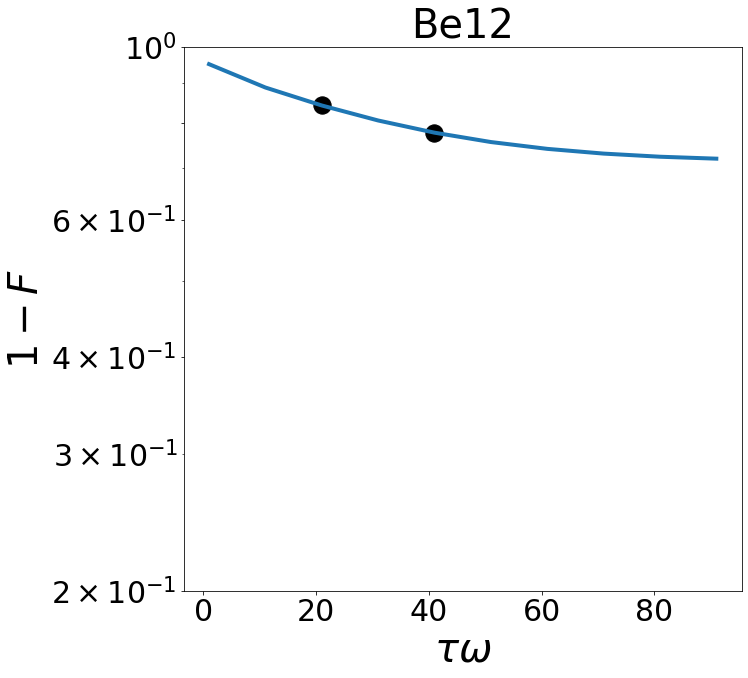

In [30]:
plt.figure(figsize=(10,10))


plt.plot(time_pure,f_vs_t,linewidth=4)

plt.scatter(time_pure[2],f_vs_t[2],s=300,color='black')
plt.scatter(time_pure[4],f_vs_t[4],s=300,color='black')
print(time_pure[2],time_pure[4])
plt.semilogy()
plt.xlabel(r'$\tau \omega$',fontsize=40)
plt.ylabel(r'$1-F$',fontsize=40)
plt.title('Be12',fontsize=40)
plt.tick_params(which='major',labelsize=30)
plt.tick_params(which='minor',labelsize=30)
plt.yticks([0.2,0.4,0.6,0.8,1])
plt.show()

##### Plot of the annealing procedure

(200,)


/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/text.py:831: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(self._y))
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/text.py:691: ComplexWarning: Casting complex values to real discards the imaginary part
  posy = float(self.convert_yunits(self._y))


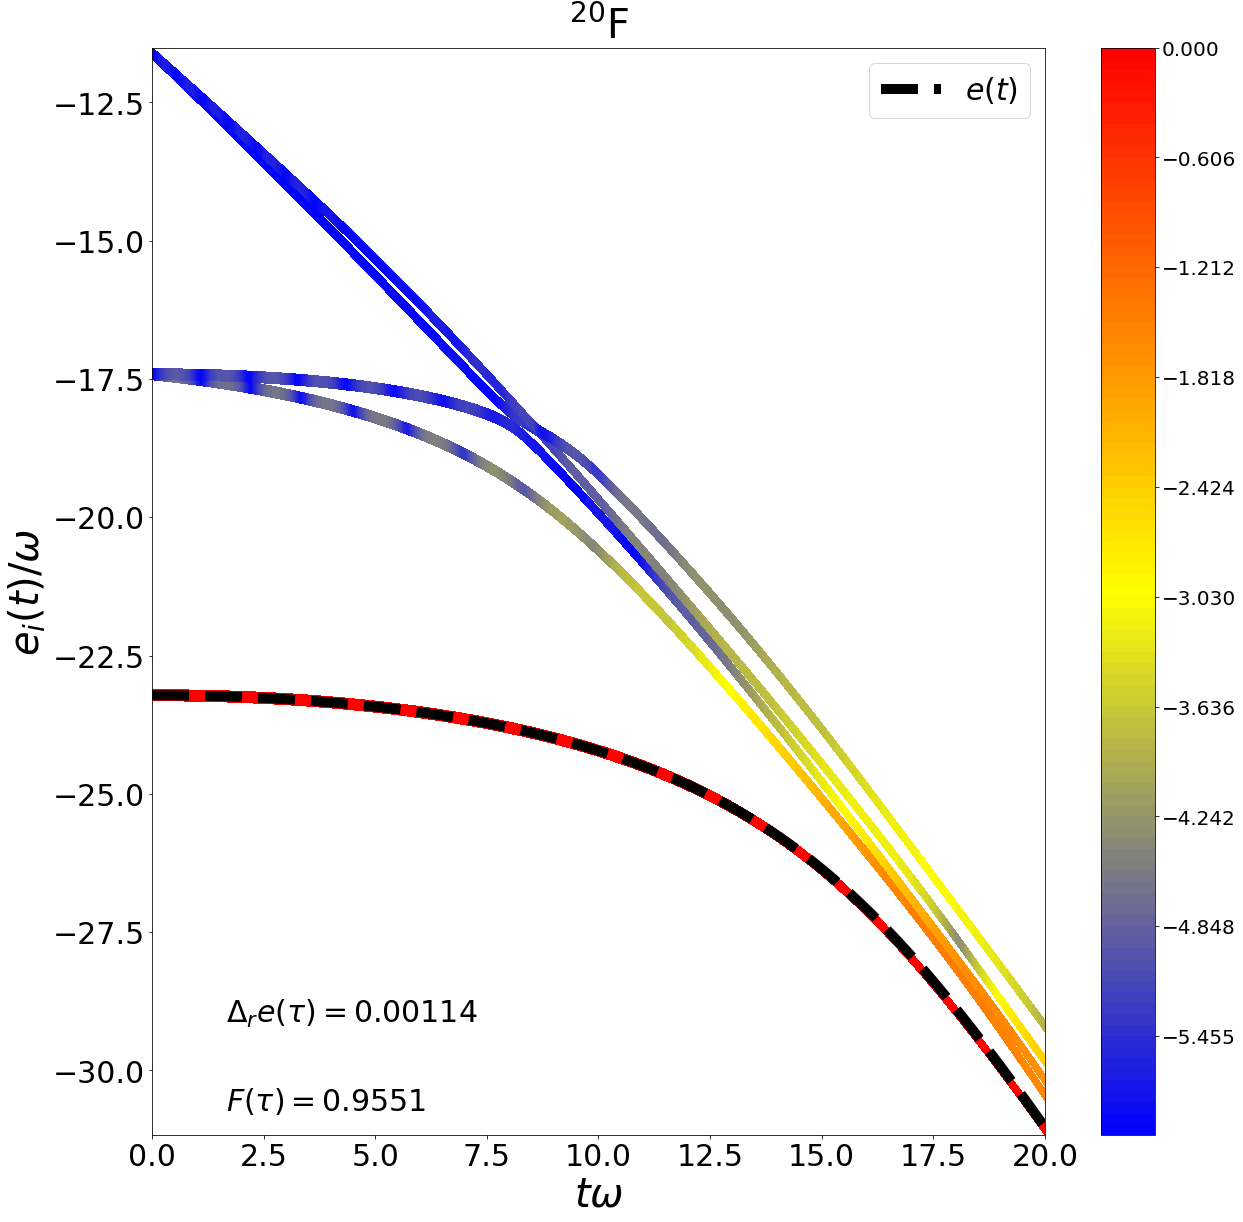

In [79]:
levels_studied=5
from matplotlib.colors import LinearSegmentedColormap
# Create a custom colormap from blue to yellow to red
cmap = LinearSegmentedColormap.from_list(
    'contrast_map',
    [(0, 0, 1, 1), (1, 1, 0, 1), (1, 0, 0, 1)]  # Blue -> Yellow -> Red
)
fig=plt.figure(figsize=(20,20))


levels_studied=probabilities.shape[0]
probs=np.log10(probabilities[:levels_studied]+10**-6)
vmax=np.max(probs)
vmin=np.min(probs)
print(time.shape)

norm = plt.Normalize(-6, 0)

#ax[0].plot(time_be8, spectrum_be8[0],color='red',linewidth=8)
plt.plot(time, eng_t,color='black',linewidth=10,linestyle='--',label=r'$e(t)$')

#for i in range(0,levels_studied):
#    plt.plot(time_be8, spectrum_be8[i],color='grey',linewidth=1)

scatters = []
for i in range(0,levels_studied):
    dy_plus=spectrum[i]+0.1
    dy_minus=spectrum[i]-0.1
    y_2d=np.zeros((dy_plus.shape[0],10))
    x_2d=np.zeros((dy_plus.shape[0],10))
    prob_2d=np.zeros((dy_plus.shape[0],10))
    for r in range(dy_plus.shape[0]):
        y_2d[r,:]=np.linspace(dy_minus[r],dy_plus[r],10)
        x_2d[r]=time[r]
        #if probs[i,r]<-15:
        #    prob_2d[r]=-10
        #else:
        #    prob_2d[r]=probs[i,r]
        prob_2d[r]=probs[i,r]
    #ax[2].plot(time_si, spectrum_si[i],color='grey',linewidth=1)
    levels = np.linspace(vmin, vmax, 100)
    contourt=plt.contourf(x_2d, y_2d, prob_2d,cmap=cmap,levels=levels)
#gs_scatter=plt.scatter(time,eng_t[:],c=probabilities[0,:],linestyle='--',linewidth=3,cmap='viridis',norm=norm)
#tot_scatters.append(gs_scatter)
cbar = plt.colorbar()

# Increase the tick size
cbar.ax.tick_params(labelsize=20) 

# plt.xlim([0.9,1])
plt.xlabel(r'$t \omega$',fontsize=40)
plt.ylabel(r'$e_i(t)/ \omega$',fontsize=40)
plt.text(x=10*1/6,y=eng_t[-1]+0.3,s=r'$F(\tau)=$'+f'{fidelity.real:.4f}',fontsize=30)
plt.text(x=10 * 1 / 6, y=eng_t[-1]+1.9, s=r"$\Delta_r e(\tau)=$" + f"{np.abs((eng_t[-1].real-egs)/egs):.5f}", fontsize=30)

# plt.text(
#     x=10 * 1 / 6,
#     y=eng_t_be8[-1]+1,
#     s=r"$^{8}$Be",
#     fontsize=30,
# )

plt.title(title,fontsize=40)
plt.tick_params(which='major',labelsize=30)

#plt.text(x=5,y=-21,s=r'$^{8}$Be',fontsize=40)
plt.legend(fontsize=30,loc='upper right')





#### Population plot

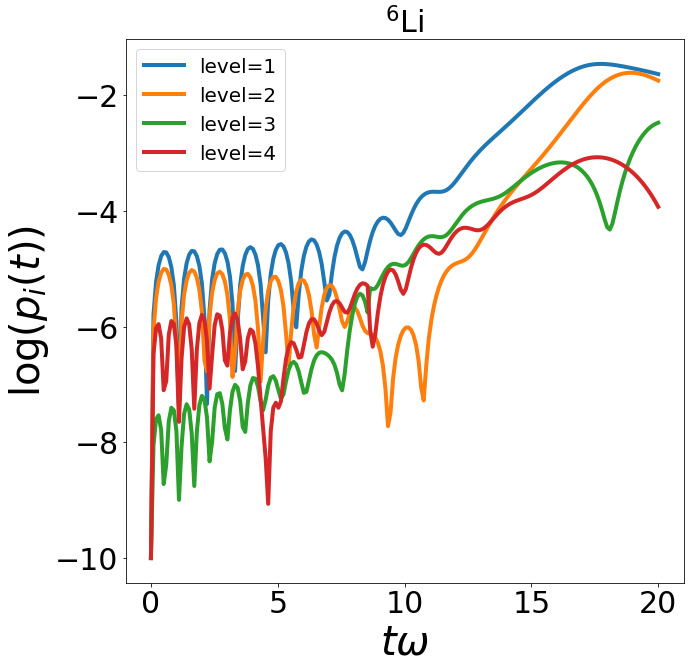

In [39]:
plt.figure(figsize=(10,10))
for i in range(1,5):
    
    plt.plot(time,np.log10(probabilities[i]+10**-10),label=f'level={i}',linewidth=4)
    # just for the Li6
    #plt.plot(time,(probabilities[i]+10**-10),label=f'level={i}',linewidth=4)


#plt.semilogy()
plt.legend(fontsize=20)
plt.tick_params(which='major',labelsize=30)
plt.xlabel(r'$t \omega$',fontsize=40)
plt.ylabel(r'$\log(p_i (t))$',fontsize=40)
# just for the Li6
#plt.ylabel(r'$p_i (t)$',fontsize=40)

plt.title(r'$^{6}$Li',fontsize=30)
plt.show()

#### $\tau$ vs Fidelity

In [68]:
tfs = np.array([10,20,30])
nsteps =100*tfs
nlevels=20

#gamma=1/(tf/2)
#lambd=np.exp(-gamma*time)
fidelities=[]
relative_err=[]
for a in range(tfs.shape[0]):
    tf=tfs[a]
    nstep=int(nsteps[a])
    time = np.linspace(0.0, tf, nstep)
    psi = psi_initial
    dt=time[1]-time[0]
    lambd=1-time/tf
    for i in trange(nstep):

        time_hamiltonian = (
            InitialHamiltonian.hamiltonian * ( lambd[i])
            + TargetHamiltonian.hamiltonian * (1-lambd[i])
        ) #+lambd[i]*(1-lambd[i]) * IntermediateHamiltonian.hamiltonian
        values, psis = eigsh(time_hamiltonian, k=nlevels, which="SA")
        psi=expm_multiply(-1j*dt*time_hamiltonian,psi)

        e_ave=psi.conjugate().transpose()@ time_hamiltonian @ psi
        e_square_ave = (
            psi.conjugate().transpose() @ time_hamiltonian @ time_hamiltonian @ psi
        )
        
    degenerate_fidelity=0.
    count=0
    for j in range(values.shape[0]):
        if np.isclose(values[j],values[0]):
            degenerate_fidelity += (
                psis[:, j].conjugate().transpose() @ psi[:]
            ) * np.conj(psis[:, j].conjugate().transpose() @ psi[:])
            count=count+1

    print('fidelity=',degenerate_fidelity,'relative energy error=',e_ave,'\n')
    fidelities.append(degenerate_fidelity)
    relative_err.append(np.abs((egs-e_ave)/egs))    


fidelities=np.asarray(fidelities)
relative_err=np.asarray(relative_err)


100%|██████████| 710/710 [00:01<00:00, 459.10it/s]


fidelity= (0.9818778191777102+0j) relative energy error= (-14.41750753338667+0j) 



100%|██████████| 1421/1421 [00:03<00:00, 461.21it/s]


fidelity= (0.9967470920808814+0j) relative energy error= (-14.482206705971707+0j) 



100%|██████████| 2132/2132 [00:04<00:00, 460.79it/s]

fidelity= (0.9991710748522994+0j) relative energy error= (-14.492468460430427+0j) 



##### Plots

NameError: name 'tfs' is not defined

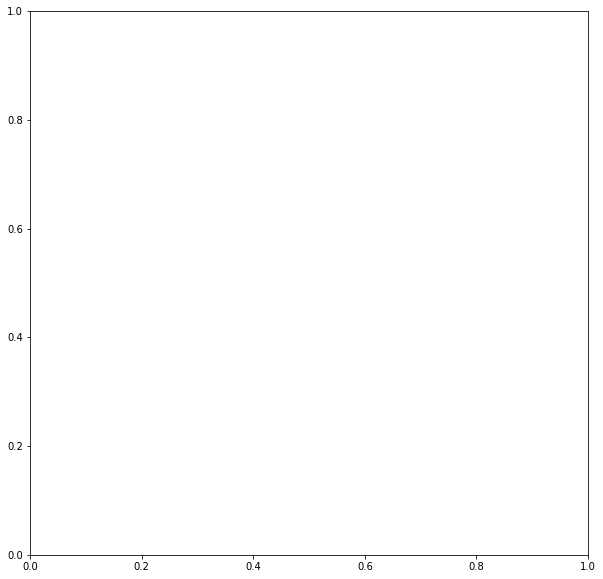

In [35]:
fig,ax=plt.subplots(figsize=(10,10))
ax.plot(tfs*average_unit_energy,1-fidelities,label=r'$1-F$',color='blue',linewidth=4,linestyle='-')
ax.scatter(tfs*average_unit_energy,1-fidelities,color='blue',s=100)
ax.semilogy()
ax.set_xlabel(r'$\tau \omega $',fontsize=40)
ax.set_ylabel(r'$1-F$',fontsize=40)
ax_twin=ax.twinx()
ax_twin.plot(tfs*average_unit_energy,relative_err,cllabel=r'$|\Delta_r e|$',color='red',linewidth=4,linestyle='--')
ax_twin.scatter(tfs*average_unit_energy,relative_err,color='red',s=100)
ax.legend(fontsize=30)
ax_twin.semilogy()
ax_twin.legend(fontsize=30,loc='lower left')
ax_twin.set_ylabel('$|\Delta_r e|$',fontsize=40)
ax.tick_params(which='major',labelsize=30)
ax_twin.tick_params(which='major',labelsize=30)
plt.show()